# Learning Tonotactic Patterns over Autosegmental Representation with BUFIA
---


## Part 1 Convert String to ASR

In [98]:
# -*- coding: utf-8 -*-
import os
import re
import pandas as pd
import graphviz


## set the phonology
h_tone = "áéíóú"
l_tone = "àèìòù"
f_tone = "âêîôû"
r_tone = "ǎěǐǒǔ"
vowels = h_tone + l_tone + r_tone + f_tone + 'aeiou'

class Autorep:
    
    def __init__(self, word="", mel='', mora = 0, ocp_mel="", assoc=None):
        """
        Initialize an Autorep object.

        Parameters:
        - word (str): The word with tone markers. 
        - tone (str): The tone markers directly extracted from the word(HFLR). 
        - mel (str): The melody (F -> HL and R -> LH) before OCP. 
        - ocp_mel (str): The OCP-applied tone representation of the word. 
        - assoc (list): A list of tuples (j,k) indicating the association 
                        between tone (indexed by j)
                                mora (indexed by i) 
                                syllable (indexed by k) list.
        """

        self.word = word
        self.tone = ''
        self.mel = ''
        self.ocp_mel = ocp_mel
        self.mora = mora 
        self.assoc = assoc if assoc is not None else []

  

        
        if len(self.ocp_mel) != max([j for j, k in self.assoc if j is not None], default=0):
            raise ValueError("The length of the melody does not match the number of tone units.")
        
        #assign association

        syllables = self.word.split(".")
        for i, syl in enumerate(syllables):
            mora_count = 0
            for u,  char in enumerate(syl):
                if char in vowels:
                    mora_count += 1
                elif char not in vowels:
                    # Check if the previous character was a vowel
                    if u > 0 and syl[u-1] in vowels:
                        mora_count += 1
            if mora_count > 1:
                for mora in range(mora_count-1):
                    self.assoc[i] = (i,i+mora,i)

        if not ocp_mel: #if tone is specified convert to OCP melody
            self.tone_labels = {'H': h_tone, 'L': l_tone, 'F': f_tone, 'R': r_tone}
            self.tone += ''.join(next((k for k, v in self.tone_labels.items() if seg in v), '') for seg in self.word)
            self.mel = self.tone 

            # Convert 'F' and 'R' into 'HL' and 'LH' respectively
            for i in range(len(self.tone)):
                contour_count = 0 
                self.assoc.append((i + 1, i + 1, i + 1)) 
                if self.tone[i] == 'F':
                    i,j,k = self.assoc[i]
                    self.mel = self.mel.replace('F', 'HL')
                    self.assoc.insert(2 * i + 1, (i + contour_count, i + 1, i))
                elif self.tone[i] == 'R':
                    i,j,k = self.assoc[i]
                    self.mel = self.mel.replace('R', 'LH')
                    self.assoc.insert(2 * i + 1, 2 * i + 1, (i + contour_count, i + 1))
            
            # Adjust association indices for ** tone spreading **
            for i in range(1, len(self.mel)):
                j,k,v= self.assoc[i]
                p,q,t = self.assoc[i - 1]
                if self.mel[i] == self.mel[i - 1]: # if HF -> HHL or [(1, 1), (2, 2), (3, 2)] -> [(1, 1), (1, 2), (2, 2)]
                    for j in range(i, len(self.assoc)):
                        self.assoc[j] = (self.assoc[i - 1][0], self.assoc[j][1],self.assoc[j][2])
                else:
                    j = p + 1
                    self.assoc[i] = (j, k, v)
             # Adjust association indices for ** contour two mura **


            

        #print(self.mel, self.ocp_mel, self.assoc) 
    
    def check_empty(self):
        return (self.word == "" and self.assoc == [] and self.mel == "" and self.ocp_mel == "")     


    def tone_pos(self, check_tone):
        """
        Get positions of a particular tone in the melody.
        """
        check_tone = check_tone.upper()
        if check_tone not in set(self.mel):
            return False     
        else:
            return [1 + i for i, j in enumerate(self.mel) if j == check_tone]      
    
    @staticmethod
    def index_reset(lst):
        """
        Reset indices of the association list to start from 1.
        """
        j, k = lst[0] if lst else (None, None)
        distance_k = k - 1 if k is not None else None
        distance_j = j - 1 if j is not None else None
        new_list = []
        for (j, k) in lst:
            j = j - distance_j if j is not None and distance_j is not None else None
            k = k - distance_k if k is not None and distance_k is not None else None
            new_list.append((j, k))
        return new_list 
    
    @staticmethod
    def assoc_check(assoc_list):
        if assoc_list:
            for tup in assoc_list:
                if None not in tup:
                    return True  # At least one tuple doesn't contain None, so return True
            return False  # Every tuple contains a None value, so return False
        else:

            
            return False
   
    def assoc_number(self):
        return sum(1 for tup in self.assoc if tup[0] is not None and tup[1] is not None)
   
    @staticmethod
    def sort_assoc(assoc):
        """
        Sorts the association list.

        unsorted_assoc = [(1, 1), (None, 3), (2, 1), (None, 4), (3, None)])
        sorted_assoc = [(1, 1), (2, 1), (None, 3), (3, None), (None, 4)]
        """
        
        def custom_compare(x):
            if x is None:
                return float('inf')  # Treat None bigger than any other value
            else:
                return x
            
        sorted_assoc = sorted(assoc, key=lambda x: (custom_compare(x[1] if x[1] != None else x[0]),custom_compare(x[0] if x[0] != None else x[1])))
        return sorted_assoc

    
    def syl_num(self):
        return max([k for j, k in self.assoc if k is not None], default=0)
        
    
    def check_contain(self, ar):
        """
        Check if the Autorep object contains another Autorep object.
        """ 
        
        self.assoc = self.sort_assoc(self.assoc) #sort associations, put floating right side
        ar.assoc = ar.sort_assoc(ar.assoc)
        
        if self.check_empty() or ar.check_empty(): # empty ar contains nothing and everything contains empty
            return False if not ar.check_empty() else True 
        
        elif ar == self: #reflexivity 
            return True
        
        
        if ar.ocp_mel in self.ocp_mel:
            if ar.syl_num() <= self.syl_num():
                if ar.assoc_number() <= self.assoc_number():
                    check_position = [m.start() + 1 for m in re.finditer(r'(?={})'.format(ar.ocp_mel), self.ocp_mel)]
                    for i_match in check_position:
                        #print(f"shared {i_match} tone start from the position of {check_position}")
                        window_size = ar.assoc_number()
                        scan_time = len([tup for tup in self.assoc if tup[0] == i_match]) #if a L has multiple (2,1) (2,2)
                        restriction = [tup for tup in self.assoc if tup[0] == i_match]
                        #print(f"restriction {restriction}")
                        #print(f"scan time {scan_time}")
                        for i,tup in enumerate(restriction):
                            get_index = self.assoc.index(tup)
                            #print(f"{i} the check..")
                            #print(f"check this {[tup for tup in ar.assoc if not (tup[0] is None or tup[1] is None)]}")
                            #print(f"is contained with {self.assoc[get_index:get_index+window_size]} which resets to {self.index_reset(self.assoc[get_index:get_index+window_size])}")
                            #print(f"do they match? {self.index_reset(self.assoc[get_index:get_index+window_size]) == [tup for tup in ar.assoc if not (tup[0] is None or tup[1] is None)]}")
                            if self.index_reset(self.assoc[get_index:get_index+window_size]) == [tup for tup in ar.assoc if not (tup[0] is None or tup[1] is None)]:
                                return True
                    return False
                else:
                    return False
            else:
                return False
        else:
            return False


    def add_tone(self):
        """
        Add an unassociated tone in the AR by adding a tone to the melody and an association (j,k)
        j is one-unit increase of the tone numbers
        k is 'None' indicating the syllable is not associated with any tone unit
        """
        new_assoc = self.assoc.copy() 
        
        if self.ocp_mel == '':
            new_assoc.append((1, None))
            new_autorep = [
                Autorep(ocp_mel='H', assoc=new_assoc),
                Autorep(ocp_mel='L', assoc=new_assoc)
            ]
        else:
            if len(self.ocp_mel) == 1:
                new_ocp_mel = "HL" if self.ocp_mel == "H" else "LH"
            else:
                new_ocp_mel = self.ocp_mel + self.ocp_mel[-2] 
            new_assoc.append((len(new_ocp_mel), None))
            new_autorep = [Autorep(ocp_mel=new_ocp_mel, assoc=new_assoc)]
        
        return new_autorep



    def add_syl(self):
        """
        Add an unassociated syllable in the AR by adding an assocation (j,k)
        j is 'None' indicating the syllable is not associated w any tone unit
        k is the one-unit increase of current syllable number (the variable max_syllable)
        """
        current_syl = [k for j,k in self.assoc if k is not None]
    
        if current_syl:
            max_syllable_index = max(current_syl)
            new_assoc = self.assoc.copy()  # Create a copy to avoid modifying the original assoc list
            new_max_syllable_index = max_syllable_index +1
            new_assoc.append((None, new_max_syllable_index))
            new_autorep = [Autorep(mel = self.mel, ocp_mel = self.ocp_mel, assoc=new_assoc)]
        else:
            new_autorep = [Autorep(mel = self.mel, ocp_mel = self.ocp_mel, assoc=self.assoc + [(None, 1)])]
        
        return new_autorep
    

    def float_tone(self):
        if len(self.assoc) > 1:
            return ([(_,k) for (_,k) in reversed(self.assoc) if k is None][::-1])
        else:
            return ([(_,k) for (_,k) in self.assoc if k is None])
    

    def float_syl(self):
        return [(j,_) for (j,_) in reversed(self.assoc) if j is None][::-1]

    
    def check_float(self):
        return any([self.float_tone(),self.float_syl()])


    def float_tone_to_syl(self):
        """
        Associate the first floating tone to the last syllable
        e.g LH [(1,1), (2,None)] -> [(1,1), (2,1)]
        """
        if self.float_tone():
            doubly_linked_pair = [(j,k) for (j,k)in self.assoc if j is not None and k is not None]
            if doubly_linked_pair:
                last_valid_tuple = max(doubly_linked_pair)
                t,s = last_valid_tuple
                first_float_tone = min(((j,k) for (j,k)in self.assoc if k is None), default=(float('inf'), None))
                k,_ = first_float_tone
                first_float_tone_index = self.assoc.index(first_float_tone)
                new_assoc = self.assoc[:]
                new_assoc[first_float_tone_index] = (k,s)
                return new_assoc
        
    
    def float_syl_to_tone(self):
        if self.float_syl():
            doubly_linked_pair = [(j,k) for (j,k)in self.assoc if j is not None and k is not None]
            if doubly_linked_pair:
                last_doubly_linked_pair = max(doubly_linked_pair)
                t,s = last_doubly_linked_pair
                first_float_syl = min(((j,k) for (j,k)in self.assoc if j is None), default=(float('inf'), None))
                _,k = first_float_syl
                first_float_syl_index = self.assoc.index(first_float_syl)
                new_assoc = self.assoc[:]
                new_assoc[first_float_syl_index] = (t,k)
                return new_assoc


    def flt_syl_flt_tone(self):
        if self.float_syl and self.float_tone:  # Removed unnecessary bool() and == True
            # Renamed variables to avoid naming conflict
            min_float_tone = min(((j, k) for j, k in self.assoc if k is None), default=None)
            min_float_syl = min(((j, k) for j, k in self.assoc if j is None), default=None)

            if min_float_tone and min_float_syl:  # Check if both are not None
                new_assocline = (min_float_tone[0], min_float_syl[1])
                position_to_keep = min(self.assoc.index(min_float_tone), self.assoc.index(min_float_syl))
                position_to_remove = max(self.assoc.index(min_float_tone), self.assoc.index(min_float_syl))
                new_assoc = self.assoc[:]
                new_assoc[position_to_keep] = new_assocline
                del new_assoc[position_to_remove]  # Use del to remove an item from a list
                return new_assoc
       


    def add_assoc(self):
        if self.check_float and len(self.assoc) > 1:  
            new_ar = []
            new_assoc1 = self.flt_syl_flt_tone()
            new_assoc2 = self.float_syl_to_tone()
            new_assoc3 = self.float_tone_to_syl()   
            
            if new_assoc1 is not None:
                new_ar.append(Autorep(mel=self.mel, ocp_mel=self.ocp_mel, assoc=new_assoc1))

            if new_assoc2 is not None:
                new_ar.append(Autorep(mel=self.mel, ocp_mel=self.ocp_mel, assoc=new_assoc2))

            if new_assoc3 is not None:
                new_ar.append(Autorep(mel=self.mel, ocp_mel=self.ocp_mel, assoc=new_assoc3))
            return new_ar
        

    def next_ar(self):
        if not self.assoc:
            next_ar= [Autorep(ocp_mel= "H",mel='H', assoc= [(1,None)]),
                            Autorep(ocp_mel= "L",mel='L', assoc= [(1,None)])]#,
                          #  Autorep(ocp_mel= "", assoc= [(None,1)])]
        else:
            next_ar = []
            tone_list = self.add_tone()
            syl_list = self.add_syl()
            assoc_list = self.add_assoc()

            if tone_list is not None:
                next_ar += tone_list

            if syl_list is not None:
                next_ar += syl_list

            if assoc_list is not None:
                next_ar += assoc_list
        return next_ar    
    
    
    def t_factor(self):
        tone_num = len(self.ocp_mel)
        return tone_num
    
    def s_factor(self):
        syl_num = max([k for j, k in self.assoc if k is not None], default=0)
        return syl_num     

    def k_factor(self):
        return self.t_factor() + self.s_factor()

    def info(self):
        return Autorep(ocp_mel = self.ocp_mel, assoc = self.assoc)
    
    
    def show(self):
        return(self.ocp_mel,self.assoc) 


    def __eq__(self, other):
        return self.ocp_mel == other.ocp_mel and set(self.assoc) == set(other.assoc)
    
    
    def __str__(self):
        return f"{self.ocp_mel}, {self.assoc}"
    
    
    def __hash__(self):
        # Define a hash based on the ocp_mel attribute
        return hash(self.ocp_mel)


    def draw(self, name = ""):
        
        if not name:
            file_path = os.path.join("draft/hausa_cons", f"{self.word}" if self.word else f"{self.ocp_mel}")
        else:
            file_path = os.path.join("draft/hausa_cons", f"{name}")

        d = graphviz.Digraph(filename=file_path, format='png')

        # Define subgraph s1 (melody nodes) first
        with d.subgraph() as s1:
            s1.attr(rank='source')  # Setting rank to "source" for the first subgraph
            s1.attr(rankdir='LR')
            for i, t in enumerate(self.ocp_mel):
                s1.node(f'Mel_{i+1}', label=t, shape='circle')
            
            for i in range(len(self.ocp_mel)-1):
                s1.edge(f'Mel_{i+1}', f'Mel_{i+2}', dir='none')

        # Define subgraph s2 (sigma nodes) afterwards
        with d.subgraph() as s2:
            s2.attr(rank='same')  # Setting rank to "sink" for the second subgraph
            s2.attr(rankdir='LR')
            sigma_nodes = []  # Store sigma node names
            for j in range(self.syl_num()):
                node_name = f'Syl_{j}'
                sigma_nodes.append(node_name)
                s2.node(node_name, label='σ', shape='circle')

            # Connect all sigma nodes to each other
            for i in range(len(sigma_nodes)-1):
                s2.edge(sigma_nodes[i], sigma_nodes[i+1], dir='none')

        # Connect melody nodes to sigma nodes
        for j, k in self.assoc:
            if j is not None and k is not None:
                d.edge(f'Mel_{j}', f'Syl_{k-1}', dir='none')

        #return d.render(cleanup=True) #save as fig
        return d
    # Define all vowel categories

    def mora_count(self): 
        mora_list = []
        for syl in self.word.split("."):
            mora_count = 0
            for i, char in enumerate(syl):
                if char in vowels:
                    mora_count += 1
                elif char not in vowels:
                    # Check if the previous character was a vowel
                    if i > 0 and syl[i-1] in vowels:
                        mora_count += 1
            mora_list.append(mora_count)
        return mora_list
    

  

In [93]:
ass = [1,2,3,4,5]
ass.index(2)

1

In [99]:
a = Autorep("dûs.hù")  
a.assoc




IndexError: list assignment index out of range

### Test Autorep class by using transcriptions
Take two example, _máà_ and _mâ_ and check if a contains b:

In [2]:
# Creating Autorep objects
a = Autorep("dúhùu")  
b = Autorep("fàdámàa")  
c = Autorep("gáajìmàarée")  

# Testing containment
print("c contain a:",c.check_contain(a)) # True
print("c contain b:",c.check_contain(b)) # false
print("b contain a:",b.check_contain(a)) #   True
print("b contain c:",a.check_contain(c)) #  false
print("a contain b:",a.check_contain(b)) #  false
print("a contain c:",a.check_contain(c)) #  false

# Adding tone to b
d = b.add_tone()[0]
e = b.add_syl()[0]
f = e.add_assoc()[0]
# Testing containment with modified b (d)
print("d contains b:", d.check_contain(b))  # Should print True
print("e contains b:", e.check_contain(b))  # Should print True
print("f contains e:", f.check_contain(e))  # Should print True


c contain a: True
c contain b: False
b contain a: True
b contain c: False
a contain b: False
a contain c: False
d contains b: True
e contains b: True
f contains e: True


### Test Autorep class by using AR
In this case, we have None as floating units

In [3]:
# Define the list of Autorep objects with different ocp_mel values
autorep_list = [
    Autorep(ocp_mel="HL", assoc=[(1, 1), (2, 1), (2,2)]),
    Autorep(ocp_mel="HL", assoc=[(1, 1), (1, 2), (2,None)]),
    Autorep(ocp_mel="HL", assoc=[(1, 1), (2, 1),(None,2)]),
    Autorep(ocp_mel="HL", assoc=[(1, 1),  (2,None),(None,2)]),
    Autorep(ocp_mel="HL", assoc=[(1, None),  (2,None),(None,1),(None,2)])
   # Autorep(ocp_mel="LH", assoc=[(1, 1), (2, 1)]),
   # Autorep(ocp_mel="HLH", assoc=[(1, 1), (2, 2), (3, 2)]),
   # Autorep(ocp_mel="LHL", assoc=[(1, 1), (2, 2), (3, None)]),
   # Autorep(ocp_mel="LH", assoc=[(1, None), (2, None)]),
   # Autorep(ocp_mel="L", assoc=[(1, 1), (1, 2), (1, 3)]),
   # Autorep(ocp_mel="H", assoc=[(1, 1), (None, 2), (None, 3)]),
]

# Testing the function
for i, ar1 in enumerate(autorep_list):
    for j, ar2 in enumerate(autorep_list):
        print(f"{i} contain {j}: {ar1.check_contain(ar2)}")


0 contain 0: True
0 contain 1: False
0 contain 2: True
0 contain 3: True
0 contain 4: True
1 contain 0: False
1 contain 1: True
1 contain 2: False
1 contain 3: True
1 contain 4: True
2 contain 0: False
2 contain 1: False
2 contain 2: True
2 contain 3: True
2 contain 4: True
3 contain 0: False
3 contain 1: False
3 contain 2: False
3 contain 3: True
3 contain 4: True
4 contain 0: False
4 contain 1: False
4 contain 2: False
4 contain 3: False
4 contain 4: True


In [4]:
## regardless of association order, the function should return True
a = Autorep(ocp_mel="LH", assoc=[(1, 1), (2, 1)])
b = Autorep(ocp_mel="LH", assoc=[(2, 1), (1, 1)])
a.check_contain(b)  # Should print True


True

### Check Next_ar


In [5]:
# Define the list of Autorep objects with different ocp_mel values
autorep_list = [
    Autorep(ocp_mel="H", assoc=[(None, 1), (1, None)]),
    #Autorep(ocp_mel="L", assoc=[(None, 1), (1, None)]),
    #Autorep(ocp_mel="LH", assoc=[(1, 1), (2, 1)]),
    #Autorep(ocp_mel="HLH", assoc=[(1, 1), (2, 2), (3, 2)]),
    #Autorep(ocp_mel="LHL", assoc=[(1, 1), (2, 2), (3, None)]),
    #Autorep(ocp_mel="LH", assoc=[(1, None), (2, None)]),
    #Autorep(ocp_mel="L", assoc=[(1, 1), (1, 2), (1, 3)]),
    #Autorep(ocp_mel="H", assoc=[(1, 1), (None, 2), (None, 3)]),
    #Autorep(ocp_mel="HL", assoc=[(1, 1), (2, None), (None, 3)]),
]

# Testing the function
print("------------ Testing Next_ar------------")
for i, ar1 in enumerate(autorep_list):
    print(f"{ar1}'s next_ar:")
    for j in ar1.next_ar():
        print(j)


------------ Testing Next_ar------------
H, [(None, 1), (1, None)]'s next_ar:
HL, [(None, 1), (1, None), (2, None)]
H, [(None, 1), (1, None), (None, 2)]
H, [(1, 1)]


### Testing Empty Structure


In [6]:
empty = Autorep()
print("empty structure",empty.show())

print("------------Nxt Struc of Empty------------")
for i in empty.next_ar():
    print(i)

empty structure ('', [])
------------Nxt Struc of Empty------------
H, [(1, None)]
L, [(1, None)]


In [ ]:
LL = Autorep(ocp_mel="HL", assoc=[(1, 1), (2, 1)])

lhl = Autorep("bâutáa")
lhl.draw("lhl").render()
#a = Autorep("kútúttúrèe")
#a.show()



#a.check_contain(LL)


'draft/hausa_cons/lhl.png'

## Part 2 Implement BUFIA on two languages: Hausa and Kanuri
---


In [57]:
def convert_to_ar(filename):
    """
    Convert a text file to a list of distinct Autorep objects.
    """
    autorep_list =[]
    with open(filename, "r") as file:
        for line in file:
            autorep_list.append(Autorep(line.strip()))
            #if Autorep(line.strip()).check_contain(LL):
             #  print(line)
    autoset = []

    for i in autorep_list:
        if i.info() not in autoset:
            autoset.append(i)
    print(f'processed {len(autorep_list)} words, found {len(autoset)} ASRs in {file.name}')
    return autoset


for i in convert_to_ar("hausa.txt"):
    print(i)
    #display(i.draw("hausa/ar"))
#convert_to_ar("kanuri.txt").__str__

FileNotFoundError: [Errno 2] No such file or directory: 'hausa.txt'

In [9]:
from queue import Queue

def check_from_data(ar, positive_data):
    # Iterate over each autorep in the positive data
    for i in positive_data:
        # Check if the given autorep is a sub_structure of the current autorep in the loop
        if i.check_contain(ar):
            # If it is, return True immediately
            return True
    # If the loop completes without finding any match, return False
    return False        


def check_from_grammar(ar, grammar):
    # Iterate over each autorep in the positive data
   for i in grammar:
      # Check if the given autorep contains the structure in the grammar
      if ar.check_contain(i):
         # If it is, then the grammar check fails
         return False
   # If the loop completes without finding any match, return True
   return True

 
def bufia(file, t = 2, s = 2):
   D = convert_to_ar(file)
   t_threshold = t
   s_threshold = s

   Q = Queue()
   s0 = Autorep()  
   V = []
   G = []
   Q.put(s0)

   while not Q.empty():
      s = Q.get()
      V.append(s)
      if check_from_data(s, D):
         S = s.next_ar()
         for i in S:
            if i not in V and check_from_grammar(i, G) and i.t_factor() <= t_threshold and i.s_factor() <= s_threshold:
               Q.put(i)
      else:
         if check_from_grammar(s, G):
               # only append to the grammar if it is not a super_structure of any autorep in the grammar
               G.append(s)


   print(f'found {len(G)} constraints')
   return G 

### Hausa 

processed 664 words, found 26 ASRs in hausa.txt
found 7 constraints
2 1 LH, [(1, 1), (2, 1)]


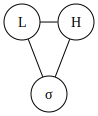

2 2 HL, [(1, 1), (1, 2), (2, 2)]


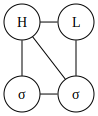

2 2 HL, [(1, 1), (2, 1), (2, 2)]


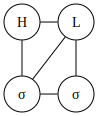

3 3 HLH, [(1, 1), (2, 2), (2, 3), (3, None)]


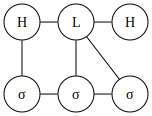

3 3 HLH, [(1, 1), (1, 2), (2, None), (1, 3), (3, None)]


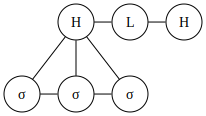

3 3 LHL, [(1, 1), (2, 2), (3, 2), (None, 3)]


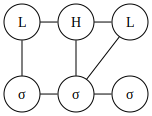

3 3 HLH, [(1, 1), (2, 1), (3, 2), (3, 3)]


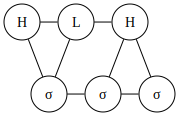

In [ ]:
hausa_grammar = bufia("hausa.txt", 3, 3)
for i, cons in enumerate(hausa_grammar):
   print(cons.t_factor(), cons.s_factor(), cons)
   display(cons.draw(f"{i}{cons.ocp_mel}t{cons.t_factor()}s{cons.s_factor()}"))
   

### Kanuri

processed 553 words, found 31 ASRs in kanuri.txt
found 9 constraints
LH, [(1, 1), (2, 1)]


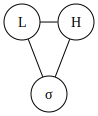

HLH, [(1, 1), (1, 2), (2, None), (3, None)]


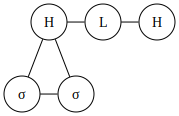

HL, [(1, 1), (1, 2), (2, 2)]


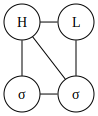

HLH, [(1, 1), (2, 1), (None, 2), (3, None), (None, 3)]


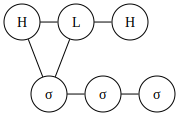

HLH, [(1, 1), (2, 1), (2, 2), (3, None)]


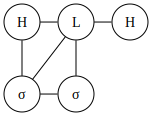

HL, [(1, 1), (1, 2), (2, None), (1, 3)]


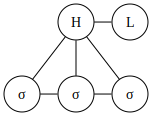

HLH, [(1, 1), (2, 2), (2, 3), (3, None)]


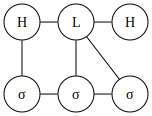

HL, [(1, 1), (2, 1), (2, 2), (2, 3)]


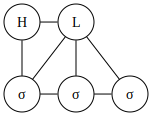

LHL, [(1, 1), (1, 2), (2, None), (1, 3), (3, None)]


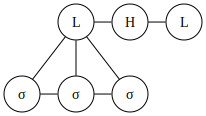

In [11]:
kanuri_grammar = bufia("kanuri.txt", 3, 3)
for i in kanuri_grammar:
   print(i)
   display(i.draw())


In [89]:
import sys
import argparse

h_tone = "áéíóú"
l_tone = "aèìòù"
f_tone = "âêîôû"
r_tone = "ǎěǐǒǔ"
monovowel = 'aeiou'

DEFAULT_VOWELS = monovowel + h_tone + l_tone + r_tone + f_tone
DEFAULT_DIPHTHVOWELS = monovowel
DEFAULT_DIPHTHONGS = {'ài', 'ái', 'âi', 'àu', 'áu', 'âu',}  # Example

DEFAULT_FSILENTS = set()


def read_vowel_file(filename):
    with open(filename,'r') as f:
        return {line.strip() for line in f}


def find_nuclei(word, vowels=DEFAULT_VOWELS, diphthvowels=DEFAULT_DIPHTHVOWELS, diphthongs=DEFAULT_DIPHTHONGS, finalsilents=DEFAULT_FSILENTS):
    syllindices = [0]*len(word)
    #mark vowels as nuclei
    for i, char in enumerate(word):
        if char in vowels or char in diphthvowels:
            syllindices[i] = -1
    #number the nuclei
    nucnum = 1
    for i, index in enumerate(syllindices):
        if index == -1:
            #in conjunction with diphthvowels, handles many diphthongs 
            if i > 0 and syllindices[i-1] != 0:
                if word[i] in diphthvowels or word[i-1] in diphthvowels or word[i-1:i+1] in diphthongs:
                    nucnum = nucnum-1
            syllindices[i] = nucnum
            nucnum += 1
    #deal with final silent vowels. If not in a diphthong, shouldn't be part of a nucleus
    if word[-1] in finalsilents and len(word) > 1 and word[-2] not in diphthvowels and word[-1] not in diphthvowels:
        syllindices[-1] = 0
    return syllindices


def segment_cluster(cluster, onsets, codas):
    for split in range(len(cluster)):
        coda = cluster[:split]
        onset = cluster[split:]
        # if we can split it into attested coda and onset, favoring longer onsets
        if (not coda or coda in codas) and (not onset or onset in onsets):
            return split
    #default by splitting the cluster in half
    return int(len(cluster)/2)


def syllabify(word, vowels=DEFAULT_VOWELS, diphthvowels=DEFAULT_DIPHTHVOWELS, diphthongs=DEFAULT_DIPHTHONGS, onsets=set(), codas=set(), finalsilents=set()):
    syllindices = find_nuclei(word, vowels, diphthvowels, diphthongs, finalsilents)
    nucindices = [i for i,syllnum in enumerate(syllindices) if syllnum > 0]
    #degenerate case with no nuclei
    if not nucindices:
        return [word]
    #for each gap between nuclei, figure out how to split into coda and onset
    for i, nucindex in enumerate(nucindices):
        if i > 0:
            #mark the onset start index
            relativeonsetindex = segment_cluster(word[nucindices[i-1]+1:nucindex],onsets,codas)
            syllindices[nucindices[i-1]+relativeonsetindex+1] = syllindices[nucindex]
    #segment the word onset to onset
    syllindices[0] = 1
    maxsyll = syllindices[nucindices[-1]]
    syllindices.append(maxsyll+1)
#    for i in range(1,maxsyll+1):
#        print i, maxsyll
#        print word[syllindices.index(i):syllindices.index(i+1)], syllindices.index(i),syllindices.index(i+1)
    return [word[syllindices.index(i):syllindices.index(i+1)] for i in range(1,maxsyll+1)]


def syllabify_textfile(textfile, vowels, diphthvowels, diphthongs, onsets, codas):
    with open(textfile, 'r') as f:
        lines = []
        for line in f:
            words = []
            for word in line.strip().split(" "):
                if word.split():
                    words.append(word.strip())
            lines.append([syllabify(word, vowels, diphthvowels, diphthongs, onsets, codas) for word in words])
        return lines


def write_output(syllabifiedlines, outputfile, delim):
    with open(outputfile, 'w') as f:
        for line in syllabifiedlines:
            words = []
            for word in line:
                words.append(delim.join(word)) 
            f.write(" ".join(words))
            if words:
                f.write("\n")

def train_clusters(textfile, vowel=DEFAULT_VOWELS, diphthvowels=DEFAULT_DIPHTHVOWELS, diphthongs=set()):
    onsets = set()
    codas = set()
    with open(textfile, 'r') as f:
        words = []
        for word in f:
            if word.split():
                words.append(word.strip())
    for word in words:
        nucindices = find_nuclei(word,vowel,diphthvowels, finalsilents=set())
        #skip if cannot be syllabified
        if max(nucindices) == 0:
            continue
#        print nucindices, word, word[:nucindices.index(1)], word[nucindices.index(max(nucindices))+1:]
        onsets.add(word[:nucindices.index(1)])
        codas.add(word[nucindices.index(max(nucindices))+1:])
    return onsets, codas

In [92]:
ons,cod = train_clusters("hausa2.txt")
cod

{'', 'a', 'e', 'i', 'k', 'm', 'n', 'o', 'r̃', 's', 'u'}

In [94]:
'123'[0:2]

'12'

In [79]:
syllabify('tsafki')

['tsaf', 'ki']

In [80]:
ons

{'',
 'b',
 'c',
 'd',
 'f',
 'fy',
 'g',
 'h',
 'j',
 'k',
 'ky',
 'l',
 'm',
 'n',
 'r',
 's',
 't',
 'w',
 'y',
 'z',
 'ƙ',
 'ƴ',
 'ɓ',
 'ɗ'}